## Image segmentation with CamVid

In [1]:
#怎樣做圖像分割呢？和其他處理類型問題的方式是一樣的。首先，構建存放數據文件的路徑變量。
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [3]:
#首先，我總是會解壓文件，執行ls，看看裡面有什麼。
#這個例子裡，有一個叫labels的標籤文件夾，和一個images文件夾。我會為這兩個文件夾創建path對象
path = untar_data(URLs.CAMVID)
path.ls()

[WindowsPath('C:/Users/User/.fastai/data/camvid/codes.txt'),
 WindowsPath('C:/Users/User/.fastai/data/camvid/images'),
 WindowsPath('C:/Users/User/.fastai/data/camvid/labels'),
 WindowsPath('C:/Users/User/.fastai/data/camvid/valid.txt')]

In [4]:
path_lbl = path/'labels'
path_img = path/'images'

## Subset classes

In [ ]:
# path = Path('./data/camvid-small')

# def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

# codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
#     'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

# src = (SegmentationItemList.from_folder(path)
#        .split_by_folder(valid='val')
#        .label_from_func(get_y_fn, classes=codes))

# bs=8
# data = (src.transform(get_transforms(), tfm_y=True)
#         .databunch(bs=bs)
#         .normalize(imagenet_stats))

## Data

In [ ]:
#數據集是CamVid它是用來做圖像分割的(Segmentation)。
#我們要要創建一張右邊這樣的用顏色標註過的圖片，裡面自行車是一種顏色、道路標線是一種顏色、樹是一種顏色、建築是一種顏色、天空是一種顏色，等等。
#
#src_size = np.array(mask.shape[1:])
#src_size,mask.data
#
#實際上我們不會給他們標顏色。我們會給每個像素一個代表類別的數值。在這個例子裡，比如左上角是建築，我猜建築是4，右上角是樹是26，等等。
#換句話說，我們會對右上角的圖像做分類問題，就像處理寵物分類的問題一樣。右上角的圖像是什麼？是一個自行車、道路標線、人行道、還是建築？
#然後是下一個圖像是什麼？我們會對每個圖片裡的每個區域，當做一個小的分類問題處理。
#################################這就是圖像分割(Segmentation Mask)。####################################
#要創建一個分割模型，你需要下載或者創建一個標註了每個區域的數據集。
#想像的出，這個工作量很大，你不用自己創建分割數據集，你可以下載或者在一些地方找到它。
#這在醫學和生命科學裡很常見。如果你瀏覽細胞核的圖片，很可能會看到很多標註過的細胞和原子核。
#如果你在做放射工作，你可能有很多標註過的病變影像的例子，等等。所以，有很多不同的領域，有專門的工具創建這樣的分割圖片。
#從這個例子裡可以猜到，它在自動駕駛，或者其它的需要看出什麼東西在附近、它們在哪裡，這樣的類似領域裡非常普遍。

In [5]:
#看看里面的内容(圖)
fnames = get_image_files(path_img)
fnames[:3]

[WindowsPath('C:/Users/User/.fastai/data/camvid/images/0001TP_006690.png'),
 WindowsPath('C:/Users/User/.fastai/data/camvid/images/0001TP_006720.png'),
 WindowsPath('C:/Users/User/.fastai/data/camvid/images/0001TP_006750.png')]

In [6]:
#看看里面的内容(標籤)
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[WindowsPath('C:/Users/User/.fastai/data/camvid/labels/0001TP_006690_P.png'),
 WindowsPath('C:/Users/User/.fastai/data/camvid/labels/0001TP_006720_P.png'),
 WindowsPath('C:/Users/User/.fastai/data/camvid/labels/0001TP_006750_P.png')]

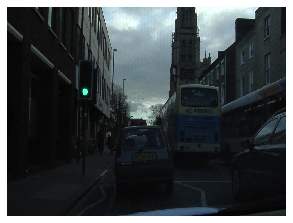

In [7]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [8]:
#通常很明顯。這裡，我猜是文件名 + _P，(第6行的WindowsPath('C:/Users/User/.fastai/data/camvid/labels/0001TP_006690"""_P""".png')
#我創建了一個簡單的函數，取文件名{x.stem}，然後加上 _P ，放到另一個目錄裡 (path_lbl) 再用get_y_fn保留
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

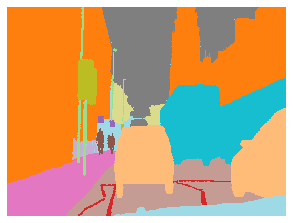

In [9]:
# 然後嘗試打開它(get_y_fn)，成功了。
# 我創建了這個把圖片文件名轉成對應的標籤文件名的簡單函數。把它打開，確認它可以用。
# 通常，我們用 open_image 來打開(正常的圖片文件)，然後你可以用.show來查看它。
# 但是，就像我們講過的，這不是普通的圖片文件，它包含的是數字。
# 所以你要用 open_masks 而不是 open_image，因為我們要返回整數而不是浮點數。
# fastai知道怎樣處理mask（遮罩），所以你執行 mask.show 時，它會自動添加顏色標註。這就是為什麼我們使用 open_masks。
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [10]:
#我們可以看看裡面，看看mask.data，看下它的大小。是720*960。
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[ 4,  4,  4,  ...,  4,  4,  4],
          [ 4,  4,  4,  ...,  4,  4,  4],
          [ 4,  4,  4,  ...,  4,  4,  4],
          ...,
          [19, 19, 19,  ..., 30, 30, 30],
          [19, 19, 19,  ..., 30, 30, 30],
          [19, 19, 19,  ..., 30, 30, 30]]]))

In [11]:
#另外一個你可能已經註意到的東西是codes.txt文件和valid.txt文件(觀察第3行輸出結果)。
#code.txt 包含一個如下所顯示列表，其中4是building(輸出結果第五項(為4)是Building)對應到上圖橘色色塊就清楚得知。
#就像我們做過的灰熊、黑熊、泰迪熊，這裡我們可以看到每個像素編號的含義。
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## Datasets

In [12]:
size = src_size//2#(//在pytorch中是指整數除法，不能留半個像素)

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 9466MB of GPU RAM free


In [13]:
#建構DataBunch我們可以使用data_block的API模組(資料來源，分割資料，標籤取得來源)
#classes=codes指分類要參考這些標籤表，因為真正參與解算是代號而非標籤本身
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [14]:
#在此執行資料變形擴增時原始圖(X)和色塊圖(Y)都要同時變形，所以這裡有呈現tfm_y=True(指色塊圖也要變形)
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

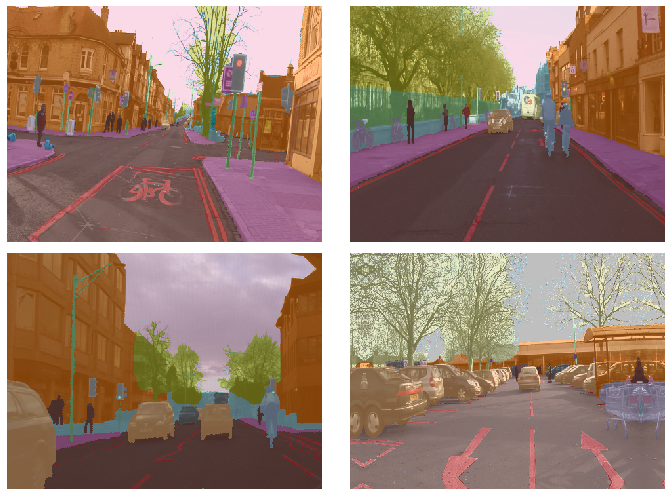

In [15]:
data.show_batch(2, figsize=(10,7))

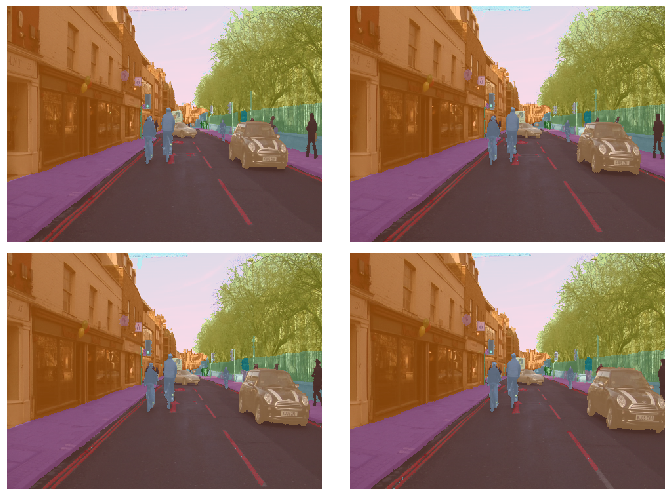

In [16]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [ ]:
#問題一、segmentation mask有沒有無監督式學習的範例??
#      若有時間可以展示，目前來說無監督式學習的segmentation mask精度及細膩度處理得不太好
#問題二、這裡可以採用64X64學習後的模型再訓練128X128再來256X256??
#      這點是絕對值得嘗試的，幾年前作者提出這論點來訓練模型不過沒有太多人關注及使，作者將此法推向實作競賽發現效果不錯
#      最近有開始出現一些論文談到此法又有別稱progressive resizing
#問題三、 對像素分割來說準確率代表什麼？是不是 (正確分類的像素數量/總的像素數量?)
#       是的，就是這樣。如果你想像每個像素都是一個要分類的對象，就是這樣計算準確率。
#       事實上，你可以直接傳入accuracy作為度量，但我們在這裡用了一個新的叫做 acc_camvid的度量指標，
#       因為它們在標註圖片時，會把有的像素標記成Void。我不太清楚為什麼，但確實有些像素是Void。
#       在CamVid論文裡，他們說，在報告準確率時，應該去除void像素。所以我們創建了accuracy CamVid方法。
#       每個度量都接收神經網絡的實際輸出（度量的輸入）和目標值（我們嘗試預測的標籤） 。
#問題四、若在更改epoch及learning-rate仍然有training-loss大於voild-loss怎麼弄??
#      這情形的發生絕對是under-fitting無庸置疑，訓練久一點、learning-rate調小一些、再來就是降低regularization(資料的正則化)、
#      weight decay(權重衰減)、dropout(丟棄)、data augmenation(資料增強)等 

In [17]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

#在這裡我們使用"acc_camvid"作為標準，在camvid論文中提及每張圖處理像素時需要將'Void'去除(至於為何在標籤圖案時有些像素會是'Void'作者也不清楚)
#在這裡的input是指NN的output值，target是他要預估的標籤
def acc_camvid(input, target):
    target = target.squeeze(1)
    #mask要的是(target不等於'Void')
    mask = target != void_code
    #input取標準的argmax，其中對比input的mask區域及target的mask區域，再取平均值
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

#這與標準的準確度函數的code差不多，只是多一行mask = target != void_code
#所以這在之後的引用準確度函數會還蠻有感覺的

In [18]:
metrics=acc_camvid
# metrics=accuracy

In [19]:
wd=1e-2

In [20]:
#對於學習模型我們可以選擇CNN不過我們這裡取用U-NETE(發表於醫療視覺影像處理)感覺更好，對於圖片分割有不錯的表現
#左邊向下的部分是一個普通的捲積網絡。它有時從一個大圖片開始，然後逐步縮小，最後僅有一個預測值。 
#U-Net做的是再把它逐步變大，把向下時每一步的值拷貝到對面，這樣就出現了一個U型。
#(資料、模型架構、評估工具矩陣)
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


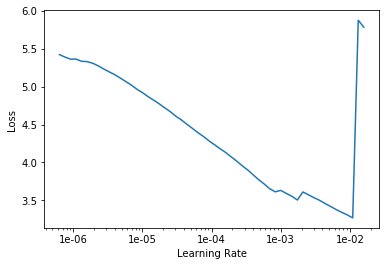

In [21]:
lr_find(learn)
learn.recorder.plot()

In [22]:
lr=3e-3

In [23]:
#先學一下，啟用learn.fit_one_cycle函數，快速觀察loss有沒有減少
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.447295,0.969615,0.753361,03:12
1,0.931635,0.709321,0.826076,03:11
2,0.727811,0.527826,0.861890,03:12
3,0.639974,0.541796,0.860563,03:13
4,0.617847,0.696936,0.813210,03:13
5,0.634712,0.539883,0.846346,03:17
6,0.571040,0.442564,0.884503,03:15
7,0.551776,0.441255,0.883836,03:14
8,0.515764,0.413886,0.880985,03:17
9,0.466776,0.332788,0.902875,03:19


In [24]:
learn.save('stage-1')

In [25]:
learn.load('stage-1');

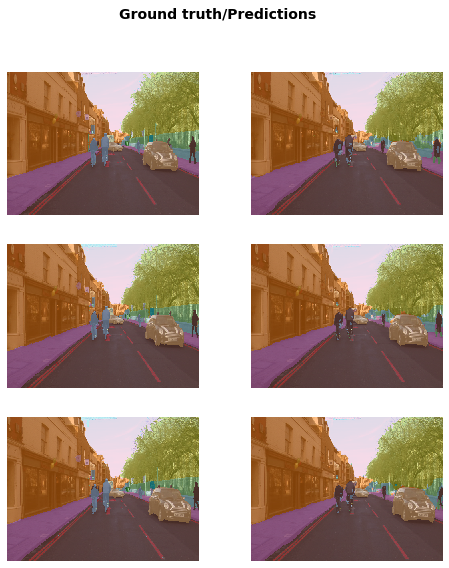

In [26]:
learn.show_results(rows=3, figsize=(8,9))

In [27]:
learn.unfreeze()

In [28]:
lrs = slice(lr/400,lr/4)

In [29]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.394371,0.324184,0.904687,03:24
1,0.385224,0.309838,0.914027,03:21
2,0.372210,0.299863,0.919526,03:22
3,0.356613,0.306515,0.910422,03:26
4,0.346617,0.308085,0.915802,03:28
5,0.337705,0.290928,0.915732,03:26
6,0.324445,0.326332,0.904682,03:30
7,0.320259,0.282461,0.922354,03:29
8,0.310978,0.309581,0.912923,03:29
9,0.298459,0.276173,0.924084,03:27


In [ ]:
#learn.fit_one_cycle
#參考資料https://forums.fast.ai/t/share-your-work-here/27676/300
#可以看到，使用正確的學習率是很重要的。如果你使用正確的學習率，它會很快找到最好位置。
#隨著你接近最小值，會發生有意思的事情，你希望你的學習率變小，因為你離正確位置很近了。
#它會像這個一樣顛簸。所以你需要一個這樣足夠高的學習率來越過顛簸，但是一旦你接近最優值，你不再希望在顛簸間來回跳動。
#你希望你的學習率變小，這樣隨著你越來越接近最優值，你的每一步越來越小。這就是為什麼我們希望學習率最後降下來。
#在訓練時降低學習率的方法存在很久了。它被稱作學習率退火（learning rate annealing）。
#但是在訓練開始時逐漸增大學習率是最近被提出的，它來自於Leslie Smith
#如果你用一個很小的學習率，它會掉進來被困在這裡。如果你逐漸增大學習率，雖然它會掉進去，但隨著學習率變大，它會像這樣再回到上面。
#然後學習率變成這樣，它會來回跳動。最終學習率漸漸變小，它會找到一條來到這個平坦部分的路。
#逐漸增大學習率是一個幫助模型探索整個函數曲線，找到平坦的、損失度低的區域的很好的方法。
#如果它是曲折的，它會被再彈出來。這讓我們能用比較高的學習率訓練，這意味這我們求解問題的速度能快很多，並且能找到泛化性更好的解。

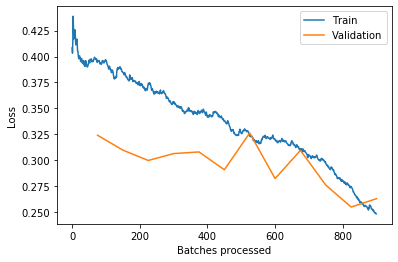

In [30]:
#可以觀察到loss先上升後下降~~~why??
learn.recorder.plot_losses()

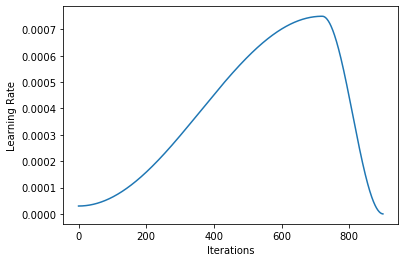

In [31]:
#在這就可以得知因為我們要fit"learn.fit_one_cycle"函數，而one_cycle的learning-rate會先升後降，所以得到相同的效果
learn.recorder.plot_lr()

In [32]:
learn.save('stage-2');

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [ ]:
"""另一個技巧混合精度訓練（Mixed precision training）
   如果你經常遇到顯卡內存溢出問題，有一個技巧來處理。你可以使用混合精度訓練。
   混合精度訓練是指，你可以使用半個精度浮點數來做模型計算，而不是使用單精度浮點數，就是使用16bit，而不是32bit。
   這個方法是最近兩年才提出的。一些硬件可以用它執行得很快。我覺得fastai第一個，也可能仍然是唯一一個能很方便地使用這個方法的。
   
   如果你把 to_fp16() 加在任何learner調用的方法的後面，你可以得到一個用16bit精度來訓練的模型。
   因為這是一個新技術，你需要使用最新的CUDA驅動和一些其它東西才能使用它。
   在有一些平台上執行它時，它會讓kernel無法工作。所以你需要用最新的驅動。
   如果你用最新的GPU，比如說2080Ti，就可以使用16bit精度，能比以前快上一倍。
   它會使用更少的GPU內存。即使你沒有2080Ti，你也可能會發現，原來在你的GPU上運行不了的代碼，在使用這個方法後，可以運行了。
   
   結果得到了更好的成績。我今天早上才發現這個，如果使用更小的浮點精度，它可以更好地泛化。
   在CamVid數據集能得到93.5%的準確率。它不僅會變快，你還能使用更大的batch size，你可能還能像我一樣得到更好的結果。這是一個很酷的小trick。"""

In [33]:
learn.destroy()

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

this Learner object self-destroyed - it still exists, but no longer usable
using bs=3, have 9198MB of GPU RAM free


In [34]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [35]:
#如果你把 .to_fp16() 加在任何learner調用的方法的後面，你可以得到一個用16bit精度來訓練的模型。
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd).to_fp16()

In [36]:
learn.load('stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


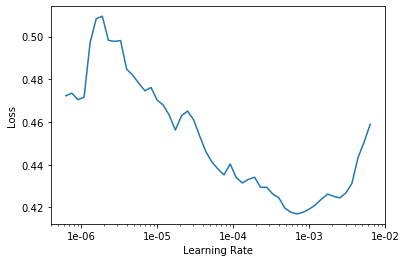

In [37]:
lr_find(learn)
learn.recorder.plot()

In [38]:
lr=1e-3

In [39]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.370075,0.328919,0.911215,06:13
1,0.333334,0.312912,0.916160,06:29
2,0.319332,0.299500,0.920048,06:25
3,0.303915,0.294586,0.922047,06:29
4,0.333299,0.282953,0.926834,06:25
5,0.328882,0.284174,0.923234,06:28
6,0.317848,0.272120,0.928526,06:17
7,0.321458,0.300331,0.920659,06:16
8,0.284104,0.296365,0.926857,06:14
9,0.222878,0.241683,0.934570,06:15


In [40]:
learn.save('stage-1-big')

In [41]:
learn.load('stage-1-big');

In [42]:
learn.unfreeze()

In [43]:
lrs = slice(1e-6,lr/10)

In [44]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.219765,0.251734,0.933155,06:30
1,0.218790,0.263524,0.930417,06:29
2,0.211007,0.252052,0.932667,06:26
3,0.209638,0.255783,0.933838,06:25
4,0.198965,0.262301,0.932458,06:28
5,0.202364,0.263337,0.934274,06:28
6,0.192292,0.276203,0.932108,06:24
7,0.186241,0.270293,0.932899,06:15
8,0.189082,0.253623,0.935203,06:14
9,0.185536,0.254699,0.935536,06:13


In [45]:
learn.save('stage-2-big')

In [46]:
learn.load('stage-2-big');

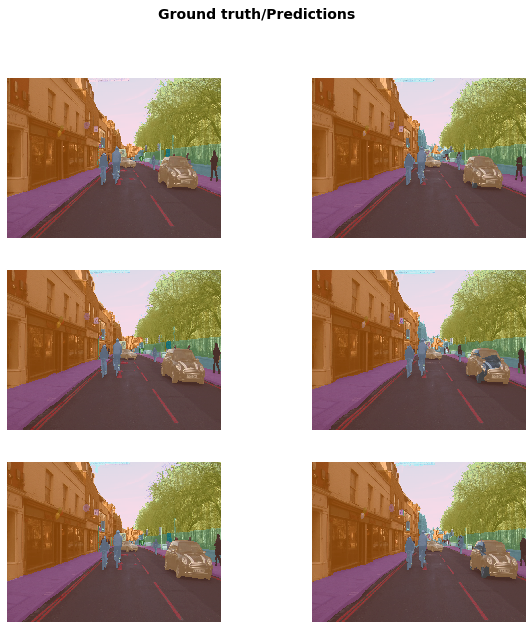

In [47]:
learn.show_results(rows=3, figsize=(10,10))

In [ ]:
#你只需要保證每次創建learner後加上 .to_fp16()。如果你的kernel被卡死了，這大概表明，你用的CUDA驅動版本太低了，或者你的顯卡太舊了。

## fin